In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from algbench import read_as_pandas
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

#matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["#890990", "#7CCBA2", "#F0746E", "#DC3977", "#7C1D6F"]) 

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [64]:
algorithm_mapping = {
    "combo": "COMBO",
    "cp-sat": "CP-SAT",
    "expknap": "Expknap",
    "greedy": "Greedy",
    "ip": "IP",
    "qtg": "QTG"
}
hue_order = [
    algorithm_mapping["combo"],
    algorithm_mapping["ip"],
    algorithm_mapping["cp-sat"],
    algorithm_mapping["greedy"],
    algorithm_mapping["qtg"]
]

qbnb_mapping = {
    "ambainis": "QBnB Amb LB",
    "montanaro": "QBnB Mon LB"
}

In [45]:
memory_baseline = {
    alg: 0 for alg in algorithm_mapping.keys()
}

memory_baseline_results = read_as_pandas('results/classical_benchmark/memory_baseline', lambda row: {
    'algorithm': row['parameters']['args']['solver'],
    'memory_kb': row['result']['maximum_resident_size_kb'],
}).groupby(['algorithm']).describe()

for alg in algorithm_mapping:
    if alg == "qtg": continue
    memory_baseline[alg] = memory_baseline_results['memory_kb']['min'][alg]

print(memory_baseline)

{'combo': 83432.0, 'cp-sat': 88632.0, 'expknap': 83464.0, 'greedy': 83392.0, 'ip': 88588.0, 'qtg': 0}


In [69]:

classical_results = read_as_pandas('results/classical_benchmark/classical_qtg_comparison', lambda row: {
    'algorithm': row['parameters']['args']['solver'],
    'algorithm_human_readable': algorithm_mapping[row['parameters']['args']['solver']],
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': row['result']['elapsed_cycles'] if 'elapsed_cycles' in row['result'] else -1,
    'instance': row['parameters']['args']['instance']['name'],
    'objective_value': row['result']['objective_value'],
    'memory_bits': (row['result']['maximum_resident_size_kb'] - memory_baseline[
        row['parameters']['args']['solver']]) * 1024 * 8,  # to bytes -> to bits
})

optimal_solutions = dict()
for i, row in classical_results[classical_results['algorithm'] == "combo"].iterrows():
    optimal_solutions[row['instance']] = row['objective_value']

qtg_results = read_as_pandas('results/quantum_benchmark/classical_qtg_comparison', lambda row: {
    'algorithm': 'qtg',
    'algorithm_human_readable': algorithm_mapping["qtg"],
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]) +
                      np.average([measure['cycle_count_decomp'] for measure in row['result']['measurements']]),
    'memory_bits': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'average_gap': np.average([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'best_gap': np.min([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'success_probability': sum([1 for measure in row['result']['measurements'] if
                                measure['objective_value'] == optimal_solutions[
                                    row['parameters']['args']['instance']['name']]]) / len(
        row['result']['measurements']),
    'instance': row['parameters']['args']['instance']['name']
})

qbnb_results = read_as_pandas('results/qbnb/classical_qtg_comparison', lambda row: {
    'algorithm': row['parameters']['args']['alg_params']['algorithm'],
    'algorithm_human_readable': qbnb_mapping[row['parameters']['args']['alg_params']['algorithm']],
    'elapsed_cycles_lb': row['result']['elapsed_cycles_lb'],
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name']
})

ctg_results = read_as_pandas('results/ctg/classical_qtg_comparison', lambda row: {
    'algorithm': 'ctg',
    'algorithm_human_readable': 'CTG',
    'elapsed_cycles': np.average(row['result']['elapsed_cycles']),
    'success_probability': sum([1 for obj in row['result']['objective_values'] if
                                obj == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(
        row['result']['objective_values']),
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name'],
    'qtg_estimate_cycles': np.average(
        [it * row['result']['qtg_cycles'] for it in row['result']['total_iterations']]),
    'qtg_estimate_memory_bits': row['parameters']['args']['instance']['size'] +
                                np.log2(row['parameters']['args']['instance']['capacity']) +
                                np.log2(optimal_solutions[row['parameters']['args']['instance']['name']]) +
                                max(row['parameters']['args']['instance']['size'],
                                    np.log2(row['parameters']['args']['instance']['capacity']),
                                    np.log2(optimal_solutions[row['parameters']['args']['instance']['name']])
                                    ) + 1,
})

['COMBO' 'QTG' 'CTG' 'QBnB Amb LB' 'QBnB Mon LB']


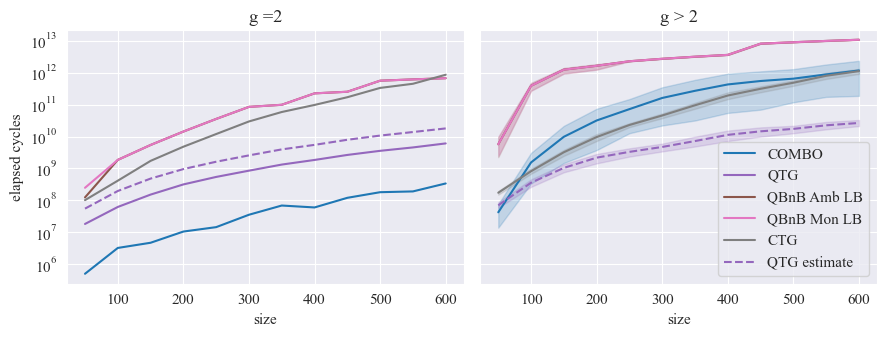

In [110]:
qbnb_results_cpy = qbnb_results.copy()
qbnb_results_cpy['elapsed_cycles'] = qbnb_results_cpy['elapsed_cycles_lb']
elapsed_cycles_comparison = pd.concat([
    classical_results[classical_results['algorithm'] == "combo"], 
    qtg_results,
    ctg_results,
    qbnb_results_cpy
])
elapsed_cycles_comparison['g'] = elapsed_cycles_comparison.apply(lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)
elapsed_cycles_comparison['g'] = elapsed_cycles_comparison.apply(lambda row: "=2" if row['g'] == 2 else "> 2", axis=1)

elapsed_cycles_comparison["algorithm"] = elapsed_cycles_comparison["algorithm_human_readable"]

fig, axs = plt.subplots(figsize=(9, 3.5), ncols=2)


print(elapsed_cycles_comparison["algorithm"].unique())
elapsed_cycles_hue_order = list(hue_order)
elapsed_cycles_hue_order.append(qbnb_mapping["ambainis"])
elapsed_cycles_hue_order.append(qbnb_mapping["montanaro"])
elapsed_cycles_hue_order.append("CTG")

for i, val in enumerate(sorted(list(elapsed_cycles_comparison['g'].unique()))):
        
    sns.lineplot(elapsed_cycles_comparison[elapsed_cycles_comparison['g'] == val], 
                 x='size', y='elapsed_cycles', 
                 hue='algorithm', hue_order=elapsed_cycles_hue_order, ax=axs[i])
    
    sns.lineplot(elapsed_cycles_comparison[
                         (elapsed_cycles_comparison['g'] == val) & 
                         (elapsed_cycles_comparison['algorithm'] == "CTG")
                     ],
                     x='size', y='qtg_estimate_cycles', ax=axs[i], label="QTG estimate", linestyle='--', color="C4")
        
    axs[i].set_title(f"g {val}")

    axs[i].set_yscale('log')
    axs[i].set_ylabel("elapsed cycles")
    legend = axs[i].legend()
    texts = [algo.get_text() for algo in legend.get_texts()]
    lines = legend.get_lines()
    legend.remove()

axs[0].set_ylim(axs[0].get_ylim()[0], axs[1].get_ylim()[1])
axs[1].set_ylim(axs[0].get_ylim()[0], axs[1].get_ylim()[1])
axs[1].set_yticklabels([])
axs[1].set_ylabel("")

axs[1].legend(lines[0:1] + lines[4:], texts[0:1] + texts[4:], loc='best', ncol=1)

fig.tight_layout()
fig.savefig('out/05_elapsed_cycles.pdf', bbox_inches='tight')
#_ = ax.legend(lines[0:1] + lines[4:], texts[0:1] + texts[4:], loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG")
sns.lineplot(ctg_results, x='size', y='success_probability', ax=ax, label="CTG")

In [6]:
memory_comparison = pd.concat([classical_results[classical_results["algorithm"] != "expknap"], qtg_results])
print(len(memory_comparison["instance"].unique()))

912


Text(0, 0.5, 'memory usage (bits/qbits)')

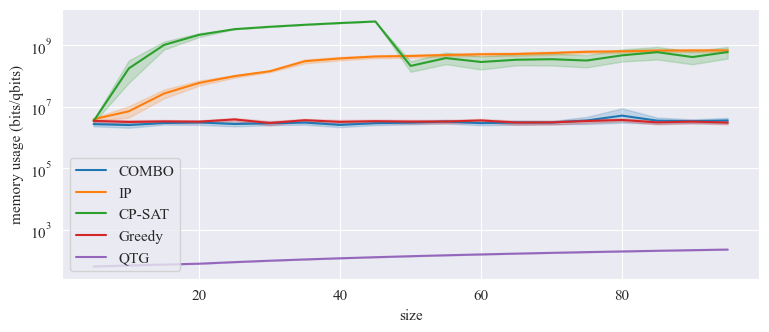

In [7]:
fig, ax = plt.subplots()
sns.lineplot(memory_comparison, x='size', y='memory_bits', hue='algorithm_human_readable', hue_order=hue_order, ax=ax)
ax.legend().set_title("")
ax.set_yscale('log')
ax.set_ylabel("memory usage (bits/qbits)")

In [8]:
memory_comparison[memory_comparison["algorithm"] == "combo"]["memory_bits"]

8       1245184.0
10      4915200.0
11      1933312.0
14      1441792.0
18      4915200.0
          ...    
4537    1998848.0
4542    3866624.0
4544    3670016.0
4545    1441792.0
4558    3440640.0
Name: memory_bits, Length: 912, dtype: float64

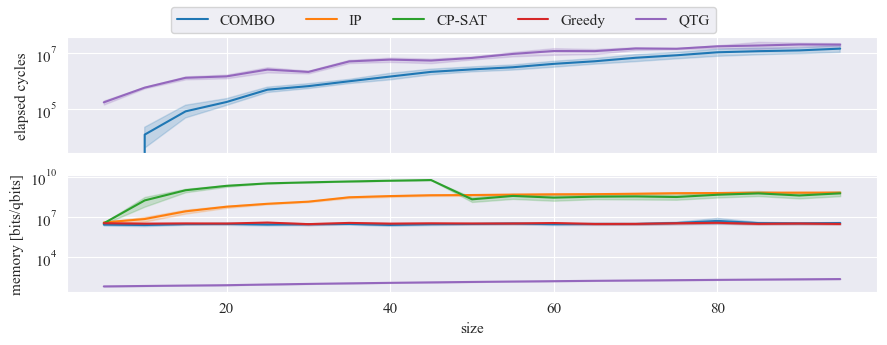

In [9]:
fig, axs = plt.subplots(nrows=2)
ax = axs[0]
sns.lineplot(elapsed_cycles_comparison, x='size', y='elapsed_cycles', hue='algorithm_human_readable',
             hue_order=hue_order, ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_yscale('log')
ax.set_ylabel("elapsed cycles")

ax = axs[1]
sns.lineplot(memory_comparison, x='size', y='memory_bits', hue='algorithm_human_readable', hue_order=hue_order, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("memory [bits/qbits]")

legend = fig.legend()
texts = [algo.get_text() for algo in legend.get_texts()]
lines = legend.get_lines()
legend.remove()

fig.legend(lines[:len(hue_order)], texts[:len(hue_order)], loc='upper center', ncol=5)

axs[0].legend().remove()
axs[1].legend().remove()

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('out/05_qtg_cycles_memory.pdf', bbox_inches='tight')

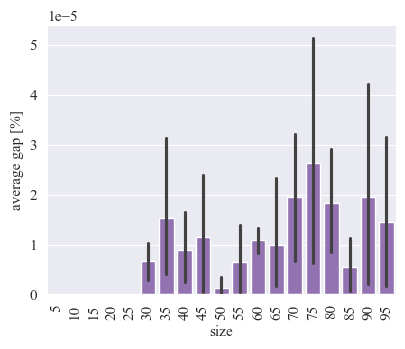

In [10]:
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.barplot(qtg_results, x='size', y='average_gap', ax=ax, color='C4')
ax.set_ylabel("average gap [%]")
ax.set_xticks(list(range(len(qtg_results['size'].unique()))))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

#ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

fig.savefig("out/05_qtg_average_gap.pdf", bbox_inches='tight')